<a href="https://colab.research.google.com/github/lspolatova/chinese/blob/development/ResNet50%20with%20font.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras import layers, losses
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.initializers import glorot_uniform
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from os import listdir
from os.path import isfile, join
import numpy as np
from PIL import Image, ImageFilter, ImageDraw, ImageFont

In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    колличество фильтров
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage - номер слоя (число)
    block -- string/character, used to name the layers, depending on their position in the network
    (тоже самое?)
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    #Internal Covariate Shift (ICS) - изменение распределения входных данных слоя нейронной сети в результате изменения параметров модели в процессе тренировки.
    #Идея BN в том, чтобы погасить этот самый ICS
    #формируют распределение с нулевым МО и единичной дисперсией.
    #делим данные на партии (батчи)
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    #число фильтров, размер, шаг, не добапвляются байты для филтра
    #Инициализатор матрицы весов
    #Метод инициализации нормального распределения Glorot
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    #Если размер равен [высота, ширина, канал], то ось равна 3. 
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
        # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
        
    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
        
    return X

In [ ]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 40965):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2, 2), name = 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (64, 64, 3), classes = 40965)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
URL = 'https://chineseplus.ru/leksika-dlya-hsk?field_level_hsk_tid=All'
HEADERS = {'user-agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Mobile Safari/537.36 Edg/95.0.1020.40', 'accept': '*/*'}

def get_html(url, params=None):
    r = requests.get(url, headers=HEADERS, params=params)
    return r

def get_pages_count(html):
    soup = BeautifulSoup(html, 'html.parser')
    if(soup.find('li', class_='pager-last')):
        pagination = int(soup.find('li', class_='pager-last').find_next('a').get('href').split('=')[-1])
        return pagination
    else:
        return 1
    
def get_content(html):
    soup = BeautifulSoup(html, 'html.parser')
    items = soup.find_all('td', class_='views-field views-field-title')
    letters = set()
    for item in items:
        word = list(item.get_text(strip=True))
        for letter in word:
            letters.add(letter)
    return letters
        
def parse():
    html = get_html(URL)
    if html.status_code == 200:      
        letters = get_content(html.text)
        pages_count = get_pages_count(html.text)
        for page in range(1, pages_count + 1):
            print(f'Парсинг страницы {page + 1} из {pages_count + 1}...')
            html = get_html(URL, params={'page': page})
            letters.update(get_content(html.text))
        print(f'Получено {len(letters)} иероглифов')
        return letters
    else:
        print('Error')

letters = parse()

Парсинг страницы 2 из 50...
Парсинг страницы 3 из 50...
Парсинг страницы 4 из 50...
Парсинг страницы 5 из 50...
Парсинг страницы 6 из 50...
Парсинг страницы 7 из 50...
Парсинг страницы 8 из 50...
Парсинг страницы 9 из 50...
Парсинг страницы 10 из 50...
Парсинг страницы 11 из 50...
Парсинг страницы 12 из 50...
Парсинг страницы 13 из 50...
Парсинг страницы 14 из 50...
Парсинг страницы 15 из 50...
Парсинг страницы 16 из 50...
Парсинг страницы 17 из 50...
Парсинг страницы 18 из 50...
Парсинг страницы 19 из 50...
Парсинг страницы 20 из 50...
Парсинг страницы 21 из 50...
Парсинг страницы 22 из 50...
Парсинг страницы 23 из 50...
Парсинг страницы 24 из 50...
Парсинг страницы 25 из 50...
Парсинг страницы 26 из 50...
Парсинг страницы 27 из 50...
Парсинг страницы 28 из 50...
Парсинг страницы 29 из 50...
Парсинг страницы 30 из 50...
Парсинг страницы 31 из 50...
Парсинг страницы 32 из 50...
Парсинг страницы 33 из 50...
Парсинг страницы 34 из 50...
Парсинг страницы 35 из 50...
Парсинг страницы 36 из

In [ ]:
import re
#letters = set()
import codecs
with codecs.open('/root/chinese-word-list.txt', encoding = 'utf-8') as f:
    for line in f:
        line = re.sub("^\s+|\n|\r|0|3|5|\s+$", '', line)
        for chin in re.findall(r'[\u3400-\u4BDF\u4E00-\u9FFF\uF900-\uFAFF\u3400-\u4BDF\u4E00-\u9FFF\uF900-\uFAFF]', line):
            for letter in line:
                letters.add(letter)
#print(letters)
f.closed

True

In [ ]:
for f in listdir('/root/font'):
    print(join('/root/font', f))

/root/font/chinese.msyh.ttf
/root/font/simkai.ttf
/root/font/chinese.simfang.ttf
/root/font/KaiTi_GB2312.ttf
/root/font/FangSong_GB2312.ttf
/root/font/SimHei.ttf


In [ ]:
counter = 0
X_data = []
for f in listdir('/root/font'):
    print(f)
    for letter in letters:
        img = Image.new('RGB', (64, 64), 'white')
        idraw = ImageDraw.Draw(img)
        line = ImageFont.truetype(join('/root/font', f), size = 44, encoding='utf-8')
        idraw.text((5, 5), letter, font = line, fill = 'black')
        X_data.append(np.asarray(img))
        counter = counter + 1
        if(not counter%1000):
            print(f'Создано картинок {counter} из {len(letters)}...')
X_data = np.array(X_data)
X_data = X_data/255.0

chinese.msyh.ttf
Создано картинок 1000 из 8193...
Создано картинок 2000 из 8193...
Создано картинок 3000 из 8193...
Создано картинок 4000 из 8193...
Создано картинок 5000 из 8193...
Создано картинок 6000 из 8193...
Создано картинок 7000 из 8193...
Создано картинок 8000 из 8193...
simkai.ttf
Создано картинок 9000 из 8193...
Создано картинок 10000 из 8193...
Создано картинок 11000 из 8193...
Создано картинок 12000 из 8193...
Создано картинок 13000 из 8193...
Создано картинок 14000 из 8193...
Создано картинок 15000 из 8193...
Создано картинок 16000 из 8193...
chinese.simfang.ttf
Создано картинок 17000 из 8193...
Создано картинок 18000 из 8193...
Создано картинок 19000 из 8193...
Создано картинок 20000 из 8193...
Создано картинок 21000 из 8193...
Создано картинок 22000 из 8193...
Создано картинок 23000 из 8193...
Создано картинок 24000 из 8193...
simsun.ttc
Создано картинок 25000 из 8193...
Создано картинок 26000 из 8193...
Создано картинок 27000 из 8193...
Создано картинок 28000 из 8193..

In [ ]:
X_data.shape

(40965, 64, 64, 3)

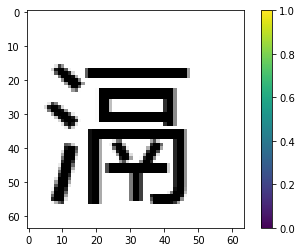

In [ ]:
plt.figure()
plt.imshow(X_data[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [ ]:
import itertools
letters = list(np.array(list(itertools.islice(itertools.cycle(letters), len(letters)*5))))
y = range(0, len(letters))

In [ ]:
prop = font_manager.FontProperties(fname='/root/simsun.ttc')
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_data[i], cmap=plt.cm.binary)
    plt.xlabel(letters[y[i]], fontproperties=prop)
plt.show()

FileNotFoundError: ignored

<Figure size 720x720 with 25 Axes>

In [ ]:
import pandas as pd
y = pd.Series(list(y))
y = pd.get_dummies(y)
y = np.array(y)
y.shape
#print(y)

(40965, 40965)

In [ ]:
 file(( model.fit(X_data, y, epochs = 100, batch_size = 32)

Epoch 1/100
1281/1281 [==============================] - 7614s 6s/step - loss: 10.9199 - accuracy: 0.0000e+00
Epoch 2/100
1281/1281 [==============================] - 7551s 6s/step - loss: 10.7172 - accuracy: 0.0000e+00
Epoch 3/100
1281/1281 [==============================] - 7472s 6s/step - loss: 10.6707 - accuracy: 0.0000e+00
Epoch 4/100
   6/1281 [..............................] - ETA: 2:04:30 - loss: 10.6680 - accuracy: 0.0000e+00